<a href="https://colab.research.google.com/github/BELBINBENORM/my_kaggle_ml_practice/blob/main/26.01.00.Predicting_Student_test_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Student Test Scores
---
####Playground Series - Season 6 Episode 1



`Upload Kaggle API key (one-time per session)`

- Go to Kaggle → Account → API → Create New Token
- Download kaggle.json

Now run the below code

In [1]:
# Upload kaggle.json when prompted
from google.colab import files
files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download -c playground-series-s6e1

# Unzip files
!unzip -o playground-series-s6e1.zip



Saving kaggle.json to kaggle.json
  0% 0.00/13.8M [00:00<?, ?B/s]
100% 13.8M/13.8M [00:00<00:00, 1.15GB/s]
Archive:  playground-series-s6e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.linear_model import LinearRegression

In [3]:
raw_train_df=pd.read_csv("train.csv")
raw_test_df=pd.read_csv("test.csv")

## EDA

In [4]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


In [5]:
X=raw_train_df.drop(columns=['id'])
X=X.drop_duplicates()

X_train = X.drop(columns=['exam_score'])
y_train = X['exam_score']
X_test = raw_test_df.drop(columns=['id'])

num_col = X_train.select_dtypes(include='number').columns
cat_col = X_train.select_dtypes(exclude='number').columns

In [6]:
# Target

y_train.describe()

,exam_score
count,630000.000000
mean,62.506672
std,18.916884
min,19.599000
25%,48.800000
50%,62.600000
75%,76.300000
max,100.000000


<Axes: >

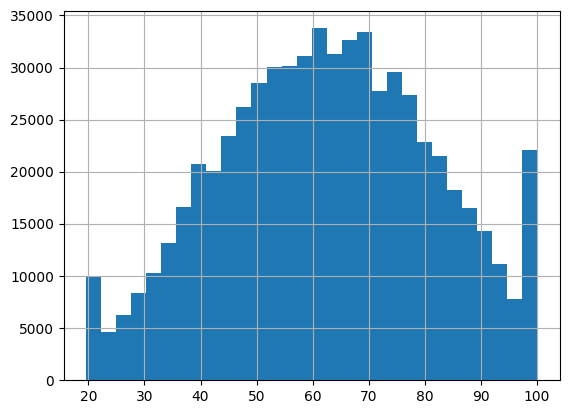

In [7]:
y_train.hist(bins=30)

In [8]:
# Numeric columns

X_train[num_col].describe()

,age,study_hours,class_attendance,sleep_hours
count,630000.000000,630000.000000,630000.000000,630000.000000
mean,20.545821,4.002337,71.987261,7.072758
std,2.260238,2.359880,17.430098,1.744811
min,17.000000,0.080000,40.600000,4.100000
25%,19.000000,1.970000,57.000000,5.600000
50%,21.000000,4.000000,72.600000,7.100000
75%,23.000000,6.050000,87.200000,8.600000
max,24.000000,7.910000,99.400000,9.900000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'study_hours'}>],
       [<Axes: title={'center': 'class_attendance'}>,
        <Axes: title={'center': 'sleep_hours'}>]], dtype=object)

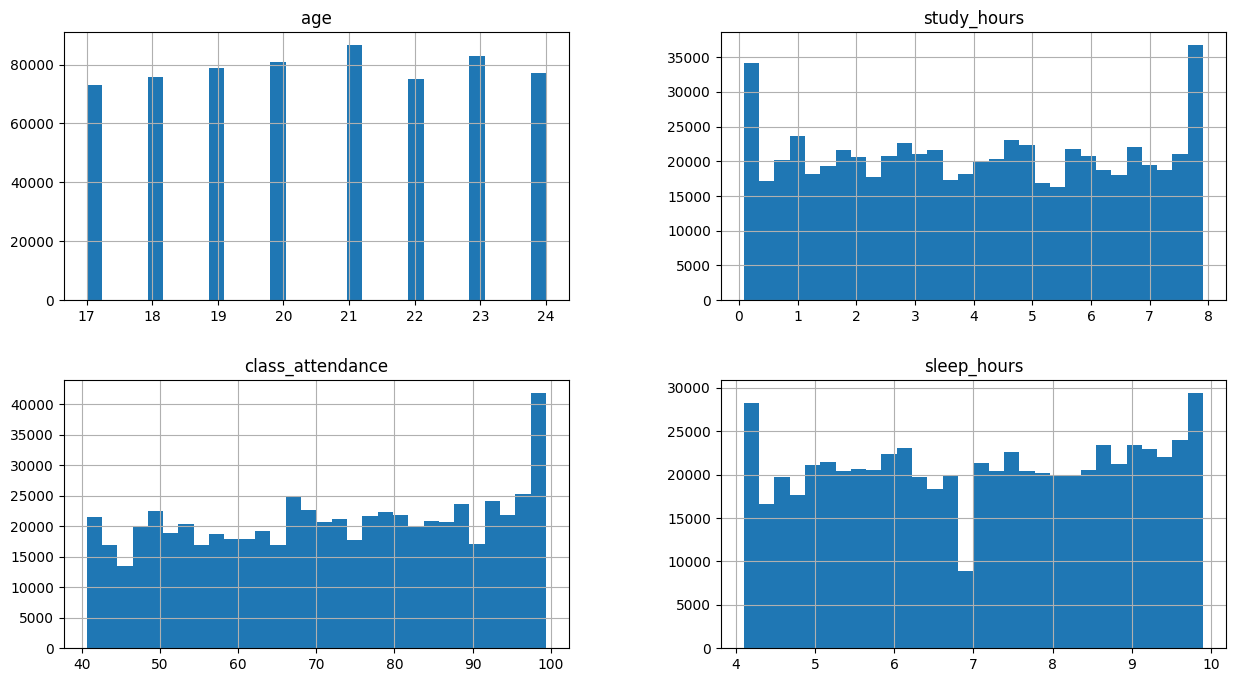

In [9]:
X_train[num_col].hist(bins=30,figsize=(15,8))

In [10]:
X_train[cat_col].describe()

,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
count,630000,630000,630000,630000,630000,630000,630000
unique,3,7,2,3,5,3,3
top,other,b.tech,yes,poor,coaching,medium,moderate
freq,211097,131236,579423,213675,131697,214082,353982


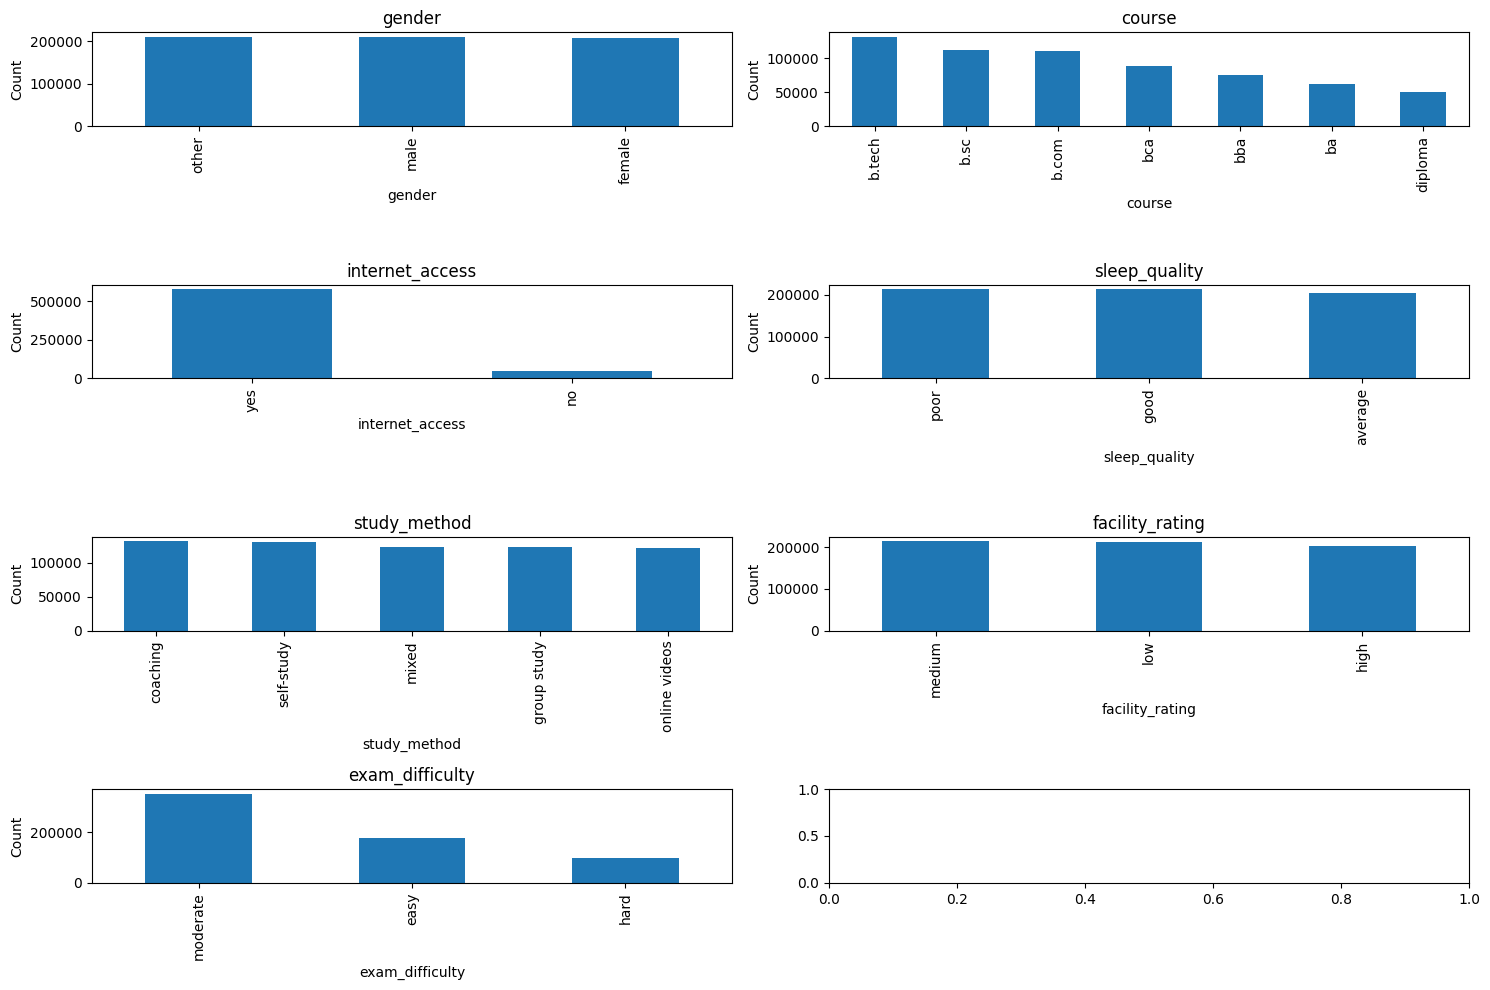

In [11]:

fig,axes = plt.subplots(4,2,figsize=(15,10))
axes = axes.flatten()

for col, ax in zip(cat_col,axes):
  X_train[col].value_counts().plot(ax=ax,kind='bar')
  ax.set_title(col)
  ax.set_xlabel(col)
  ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [12]:
cols = list(num_col)
cols.append("exam_score")
corr_matrix = X[cols].corr()
corr_matrix



,age,study_hours,class_attendance,sleep_hours,exam_score
age,1.000000,0.007545,0.005628,0.005864,0.010472
study_hours,0.007545,1.000000,0.087617,0.042491,0.762267
class_attendance,0.005628,0.087617,1.000000,0.029263,0.360954
sleep_hours,0.005864,0.042491,0.029263,1.000000,0.167410
exam_score,0.010472,0.762267,0.360954,0.167410,1.000000


## preprocessing

In [13]:
class Featur_Enginering(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass

  def fit(self,X,y=None):
    return self

  def transform(self,X):
    X = X.copy()

    X["study_efficiency"] = X["study_hours"] * X["class_attendance"]

    X["sleep_study_ratio"] = (X["sleep_hours"] / (X["study_hours"] + 1e-6))

    X["attendance_pressure"] = 1 - X["class_attendance"]

    X["age_group"] = pd.cut(X["age"],
                            bins=[0, 18, 22, 30, 100],
                            labels=["school", "college", "postgrad", "adult"])

    return X


num_normalizer = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("Normalizer",StandardScaler())
])

cat_normalizer = Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("Encoding",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])

normalizer = ColumnTransformer([
    ("num",num_normalizer,make_column_selector(dtype_include=np.number)),
    ("cat",cat_normalizer,make_column_selector(dtype_exclude=np.number))
])


In [14]:

Model = Pipeline([
    ("Feature Enginering",Featur_Enginering()),
    ("Normalizer",normalizer),
    ("Model",LinearRegression())
])

In [15]:
Model.fit(X_train,y_train)

Pipeline(steps=[('Feature Enginering', Featur_Enginering()),
                ('Normalizer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Normalizer',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d43e698fe60>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d43e7d98aa0>)])),
                ('Model', LinearRegression())])

In [16]:
y_pred = Model.predict(X_test)

In [29]:
submission=pd.DataFrame({'id':raw_test_df['id'],
                         'exam_score':y_pred})

submission.to_csv("Submission.csv", index=False)

In [ ]:
score : 8.86944